<a href="https://colab.research.google.com/github/Asigen93/Wayang/blob/main/klasifikasi_wayang_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KLASIFIKASI WAYANG KULIT (ANOMAN, BAGONG, GATOT KACA, SEMAR)

#Import Necessary Libraries

In [1]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras import Model
from tensorflow.keras.layers import Resizing, Rescaling
from PIL import Image

from pathlib import Path
import os.path
import random
import datetime

import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Load and Transform Data

In [3]:
import os
os.environ["KAGGLE_USERNAME"] = "tirtarcs" # Ganti dengan username Kaggle Anda
os.environ["KAGGLE_KEY"] = "a7cf70c0ed8f12e2ded15665175c13d4" # Ganti dengan key yang ada di kaggle.json

# Path dataset
!kaggle datasets download -d tirtarcs/datawayang

Dataset URL: https://www.kaggle.com/datasets/tirtarcs/datawayang
License(s): unknown
  0% 0.00/31.5M [00:00<?, ?B/s]
100% 31.5M/31.5M [00:00<00:00, 936MB/s]


In [4]:
# prompt: unzip file wayang.zip

!unzip datawayang.zip

Archive:  datawayang.zip
  inflating: dataset_wayang/anoman/anoman001a.jpg  
  inflating: dataset_wayang/anoman/anoman002b.jpg  
  inflating: dataset_wayang/anoman/anoman003.jpg  
  inflating: dataset_wayang/anoman/anoman003c.jpg  
  inflating: dataset_wayang/anoman/anoman004.jpg  
  inflating: dataset_wayang/anoman/anoman004d.jpg  
  inflating: dataset_wayang/anoman/anoman005.jpg  
  inflating: dataset_wayang/anoman/anoman005e.jpg  
  inflating: dataset_wayang/anoman/anoman006.jpg  
  inflating: dataset_wayang/anoman/anoman007.jpg  
  inflating: dataset_wayang/anoman/anoman008.jpg  
  inflating: dataset_wayang/anoman/anoman009.jpg  
  inflating: dataset_wayang/anoman/anoman010.jpg  
  inflating: dataset_wayang/anoman/anoman012.jpg  
  inflating: dataset_wayang/anoman/anoman014.jpg  
  inflating: dataset_wayang/anoman/anoman015.jpg  
  inflating: dataset_wayang/anoman/anoman016.jpg  
  inflating: dataset_wayang/anoman/anoman017.jpg  
  inflating: dataset_wayang/anoman/anoman020.jpg  
 

# Load and Transform Data

In [5]:
import os

# Parameter dasar
BATCH_SIZE = 64
TARGET_SIZE = (256, 256)

# Path dataset
dataset_path = "/content/dataset_wayang"  # Sesuaikan dengan lokasi hasil unzip

# Melihat struktur folder dan jumlah file di tiap kelas
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Ada {len(filenames)} file di direktori: {dirpath}")

walk_through_dir(dataset_path)

Ada 0 file di direktori: /content/dataset_wayang
Ada 80 file di direktori: /content/dataset_wayang/gatotkaca
Ada 80 file di direktori: /content/dataset_wayang/anoman
Ada 80 file di direktori: /content/dataset_wayang/semar


In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import numpy as np

# Path ke dataset asli
dataset_path = "/content/dataset_wayang"
output_aug_path = "/content/augmented_dataset"

# Parameter image
IMG_SIZE = (256, 256)
BATCH_SIZE = 64

# Augmentasi manual (bukan untuk model langsung)
augment = tf.keras.Sequential([
    layers.Resizing(*IMG_SIZE),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.05, 0.05),
])

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=1,  # 1 agar bisa augment per gambar
    shuffle=False
)

# Buat folder output augmentasi
os.makedirs(output_aug_path, exist_ok=True)

# Hitung jumlah data asli
total_original = 0
total_augmented = 0

for images, labels in dataset:
    label = labels.numpy()[0]
    class_name = dataset.class_names[label]

    # Buat folder class jika belum ada
    class_dir = os.path.join(output_aug_path, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Tambah data asli
    total_original += 1

    # Simpan 3 versi augmentasi untuk setiap gambar
    for i in range(3):  # Misal augmentasi 3x per gambar
        aug_image = augment(images, training=True)[0].numpy() * 255
        aug_image = tf.cast(aug_image, tf.uint8).numpy()

        # Simpan gambar
        save_path = os.path.join(class_dir, f"aug_{total_original}_{i}.jpg")
        tf.keras.utils.save_img(save_path, aug_image)

        total_augmented += 1

print(f"Jumlah data asli     : {total_original}")
print(f"Jumlah data augment  : {total_augmented}")
print(f"Total data baru      : {total_original + total_augmented}")

Found 240 files belonging to 3 classes.
Jumlah data asli     : 240
Jumlah data augment  : 720
Total data baru      : 960


Found 720 files belonging to 3 classes.


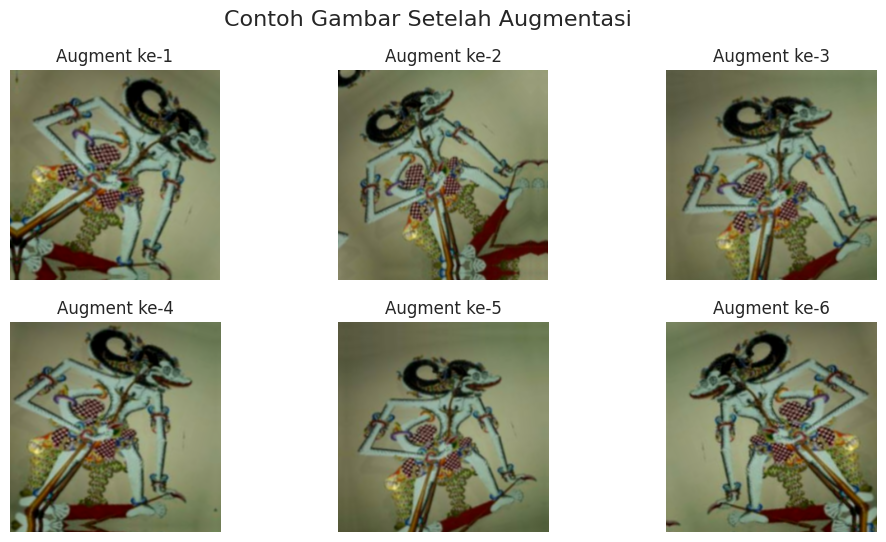

In [7]:
# Definisi augmentasi
augment = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.05, 0.05),
])

# Path dataset
dataset_path = "/content/augmented_dataset"

# Load dataset tanpa shuffle, supaya hasil stabil
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(256, 256),
    batch_size=1,  # Supaya bisa augment per gambar
    shuffle=False
)

# Ambil satu batch (satu gambar)
for images, labels in dataset.take(1):
    image = images[0]

    # Tampilkan beberapa hasil augmentasi dari gambar tersebut
    plt.figure(figsize=(12, 6))
    for i in range(6):  # Tampilkan 6 versi augmentasi
        augmented_image = augment(tf.expand_dims(image, 0), training=True)[0]
        plt.subplot(2, 3, i+1)
        plt.imshow(augmented_image)
        plt.axis("off")
        plt.title(f"Augment ke-{i+1}")
    plt.suptitle("Contoh Gambar Setelah Augmentasi", fontsize=16)
    plt.show()
    break  # hanya ambil satu gambar saja

#Placing Data into a DataFrame

In [8]:
image_dir = Path(output_aug_path)

# Dapatkan jalur file dan label
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Gabungkan jalur file dan label
image_df = pd.concat([filepaths, labels], axis=1)

/tmp/ipython-input-9-1877984030.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


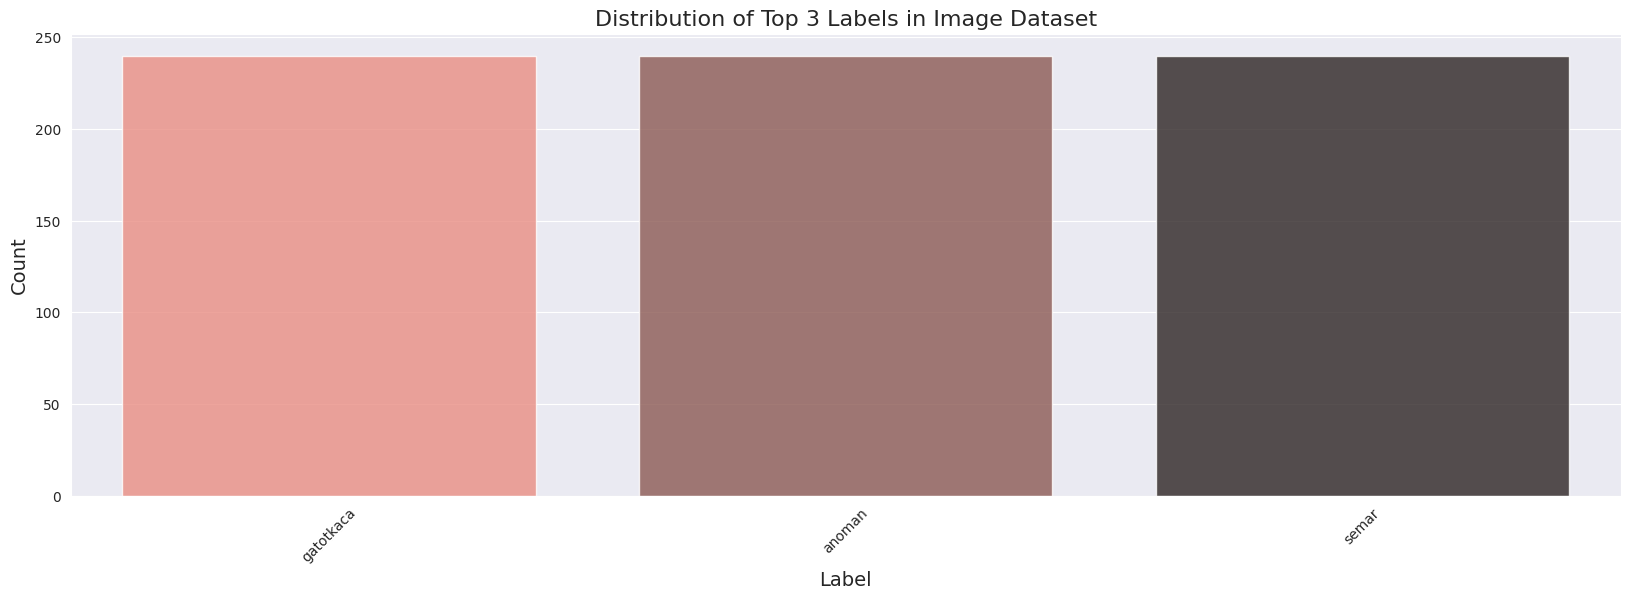

In [9]:
# Dapatkan 3 label teratas
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 3 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

#Visualizing Images from the Dataset

/tmp/ipython-input-10-2417216898.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = image_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)


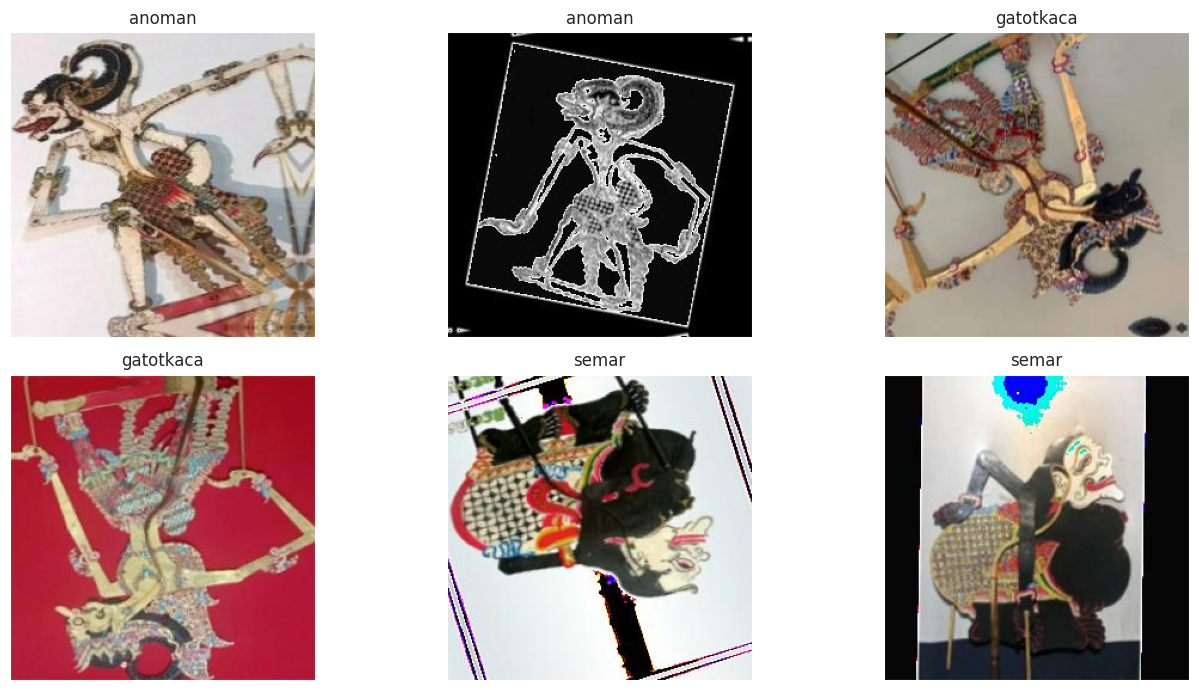

In [10]:
# Ambil 2 gambar acak dari tiap kelas
sample_df = image_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)

# Plot gambar-gambar
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = sample_df.Filepath[i]
    label = sample_df.Label[i]

    # Membaca gambar dan mengubah ukurannya menjadi persegi (256x256 misalnya)
    img = Image.open(img_path)
    img_resized = img.resize((256, 256))

    ax.imshow(img_resized)
    ax.set_title(label)

plt.tight_layout()
plt.show()

#Computing Error Rate Analysis

In [11]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Membaaca gambar yang terkompres
    compressed_img = cv2.imread(temp_filename)

    # Dapatkan perbedaan absolut antara img1 dan img2 dan kalikan dengan skala
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    # Pilih gambar acak dari folder
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

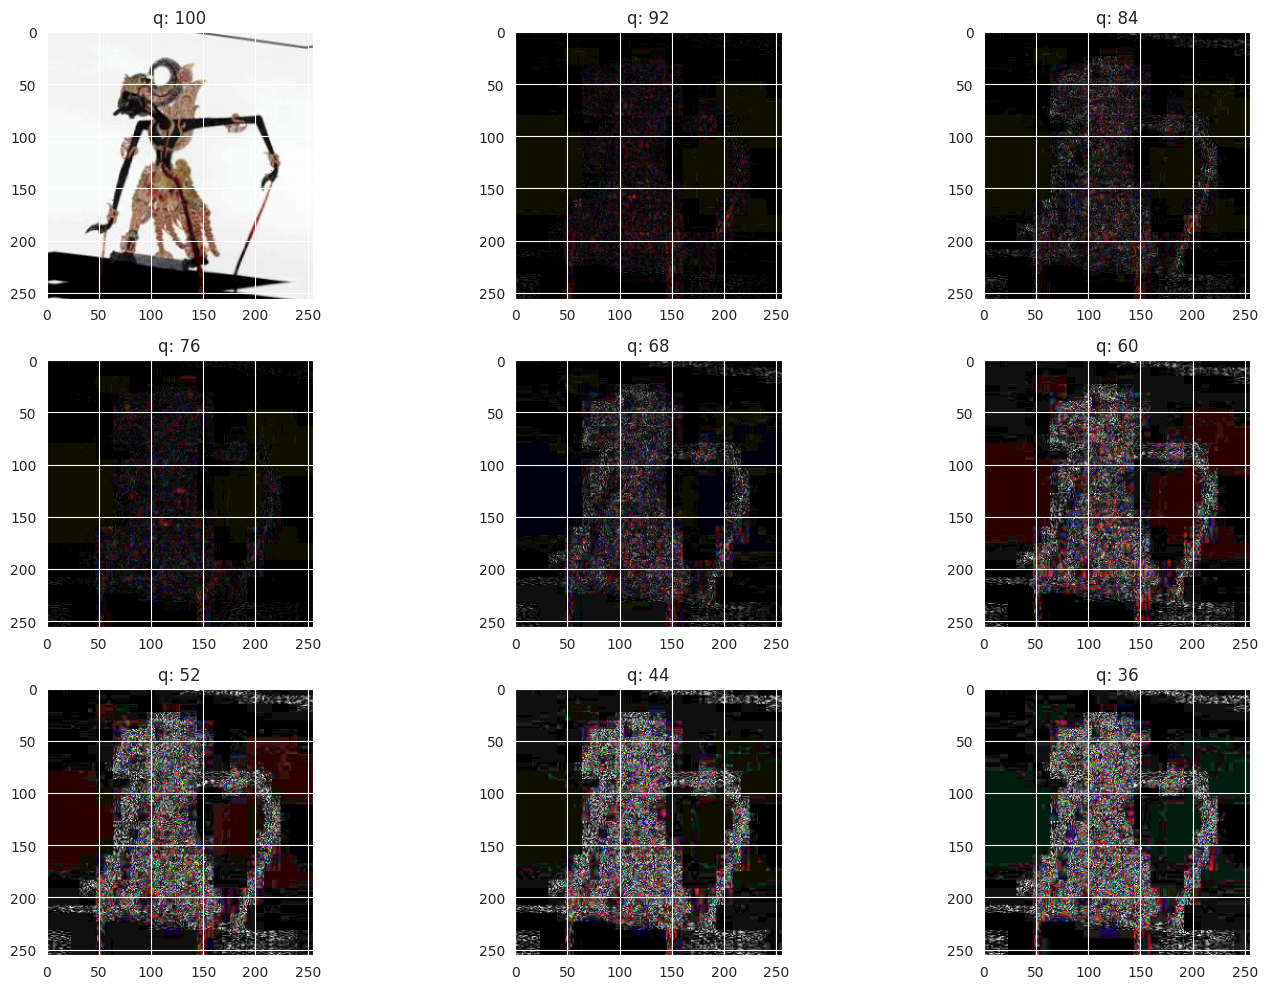

In [12]:
# Lihat sampel acak dari kumpulan data dan terapkan ELA
sample_class = 'gatotkaca'
dataset_path = '/content/augmented_dataset'
p = random_sample(f'{dataset_path}/{sample_class}')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

# Inisialisasi parameter
init_val = 100
columns = 3
rows = 3

# Membuat figure untuk plot
fig = plt.figure(figsize=(15, 10))

for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 8  # Menurunkan kualitas kompresi untuk setiap gambar
    img = compute_ela_cv(path=p, quality=quality)

    if i == 1:
        img = orig.copy()  # Gambar asli di posisi pertama

    # Mengubah ukuran gambar menjadi persegi
    img_resized = cv2.resize(img, (256, 256))  # Ganti 256 dengan ukuran yang diinginkan

    # Menambahkan gambar yang telah diresize ke dalam subplot
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img_resized)

plt.tight_layout()
plt.show()

#Data Preprocessing

**Training 75%**

**Validasi 15%**

**Test 5%**

In [13]:
# Split test set terlebih dahulu (5%)
train_val_df, test_df = train_test_split(
    image_df,
    test_size=0.05,
    shuffle=True,
    random_state=42,
    stratify=image_df['Label']
)

# Dari sisa 95%, ambil 15/95 = 0.1579 (15%) untuk validasi
val_size = 15 / 95  # 0.1579

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size,
    shuffle=True,
    random_state=42,
    stratify=train_val_df['Label']
)

# Konfirmasi ukuran
print(f"Jumlah data latih: {len(train_df)}")      # 75%
print(f"Jumlah data validasi: {len(val_df)}")     # 15%
print(f"Jumlah data uji: {len(test_df)}")         # 5%

Jumlah data latih: 576
Jumlah data validasi: 108
Jumlah data uji: 36


In [14]:
# Membuat generator untuk data latih, validasi, dan uji
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [15]:
# Membuat data generator untuk training
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk validasi
val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk testing
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 576 validated image filenames belonging to 3 classes.
Found 108 validated image filenames belonging to 3 classes.
Found 36 validated image filenames belonging to 3 classes.


In [16]:
# Menghitung jumlah gambar per kelas pada data latih
train_class_counts = train_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data latih:")
print(train_class_counts)

# Menghitung jumlah gambar per kelas pada data validasi
val_class_counts = val_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data validasi:")
print(val_class_counts)

# Menghitung jumlah gambar per kelas pada data pengujian
test_class_counts = test_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data pengujian:")
print(test_class_counts)

Jumlah gambar per kelas pada data latih:
Label
anoman       192
gatotkaca    192
semar        192
dtype: int64
Jumlah gambar per kelas pada data validasi:
Label
anoman       36
gatotkaca    36
semar        36
dtype: int64
Jumlah gambar per kelas pada data pengujian:
Label
anoman       12
gatotkaca    12
semar        12
dtype: int64


In [26]:
# Langkah Augmentasi Data
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

#Training the Model

In [27]:
# Muat VGG16 sebagai model dasar
pretrained_model = VGG16(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'  # atau 'avg' sesuai kebutuhan
)

# Freeze bobot pre-trained
pretrained_model.trainable = False

In [28]:
# Buat callback checkpoint
checkpoint_path = "wayang_vgg16.weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

# Early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

# Reduce LR
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [29]:
# **Pastikan `augment` adalah fungsi preprocessing atau pipeline augmentasi Anda**
inputs = pretrained_model.input
x = augment(inputs)

# Tambahkan Dense layers di atas feature extractor VGG16
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

# Output layer
outputs = Dense(len(train_images.class_indices), activation='softmax')(x)

# Definisikan Model
model = Model(inputs=inputs, outputs=outputs)

# Kompilasi
model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fungsi TensorBoard callback
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return TensorBoard(log_dir=log_dir)

# Training
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "wayang_vgg16"),
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 767ms/step - accuracy: 0.3182 - loss: 6.8962 - val_accuracy: 0.3796 - val_loss: 4.3263 - learning_rate: 1.0000e-05
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - accuracy: 0.3381 - loss: 6.3409 - val_accuracy: 0.3611 - val_loss: 3.8489 - learning_rate: 1.0000e-05
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 512ms/step - accuracy: 0.3471 - loss: 6.1447 - val_accuracy: 0.3426 - val_loss: 3.4352 - learning_rate: 1.0000e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step - accuracy: 0.3444 - loss: 6.0973 - val_accuracy: 0.3611 - val_loss: 3.0626 - learning_rate: 1.0000e-05
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 521ms/step - accuracy: 0.3669 - loss: 6.2844 - val_accuracy: 0.3796 - val_loss: 2.7309 - learning_rate: 1.0000e-05
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 526ms/step - accuracy: 0.3866 - loss: 5.5163 - val_accuracy: 0.3796 - val_loss: 2.4589 - learning_rate: 1.0000e-05
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 549ms/step - accuracy: 0.3509 - loss

#Model Evaluation

In [30]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.49879
Test Accuracy: 88.89%


#Visualizing Loss Curves

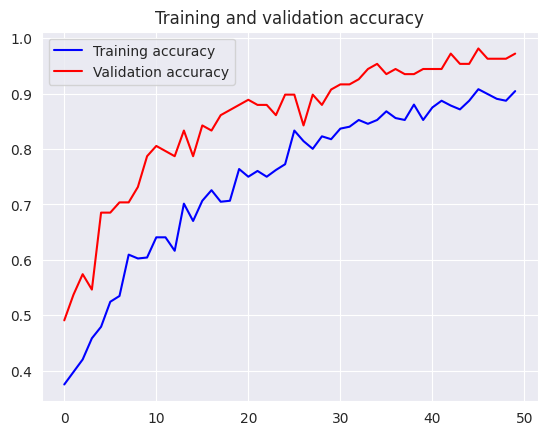

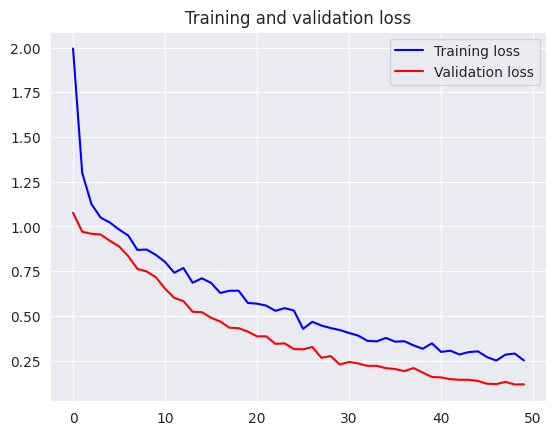

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

#Making Predictions on the Test Data

In [ ]:
# Predict label test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Petakan label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 11s/step


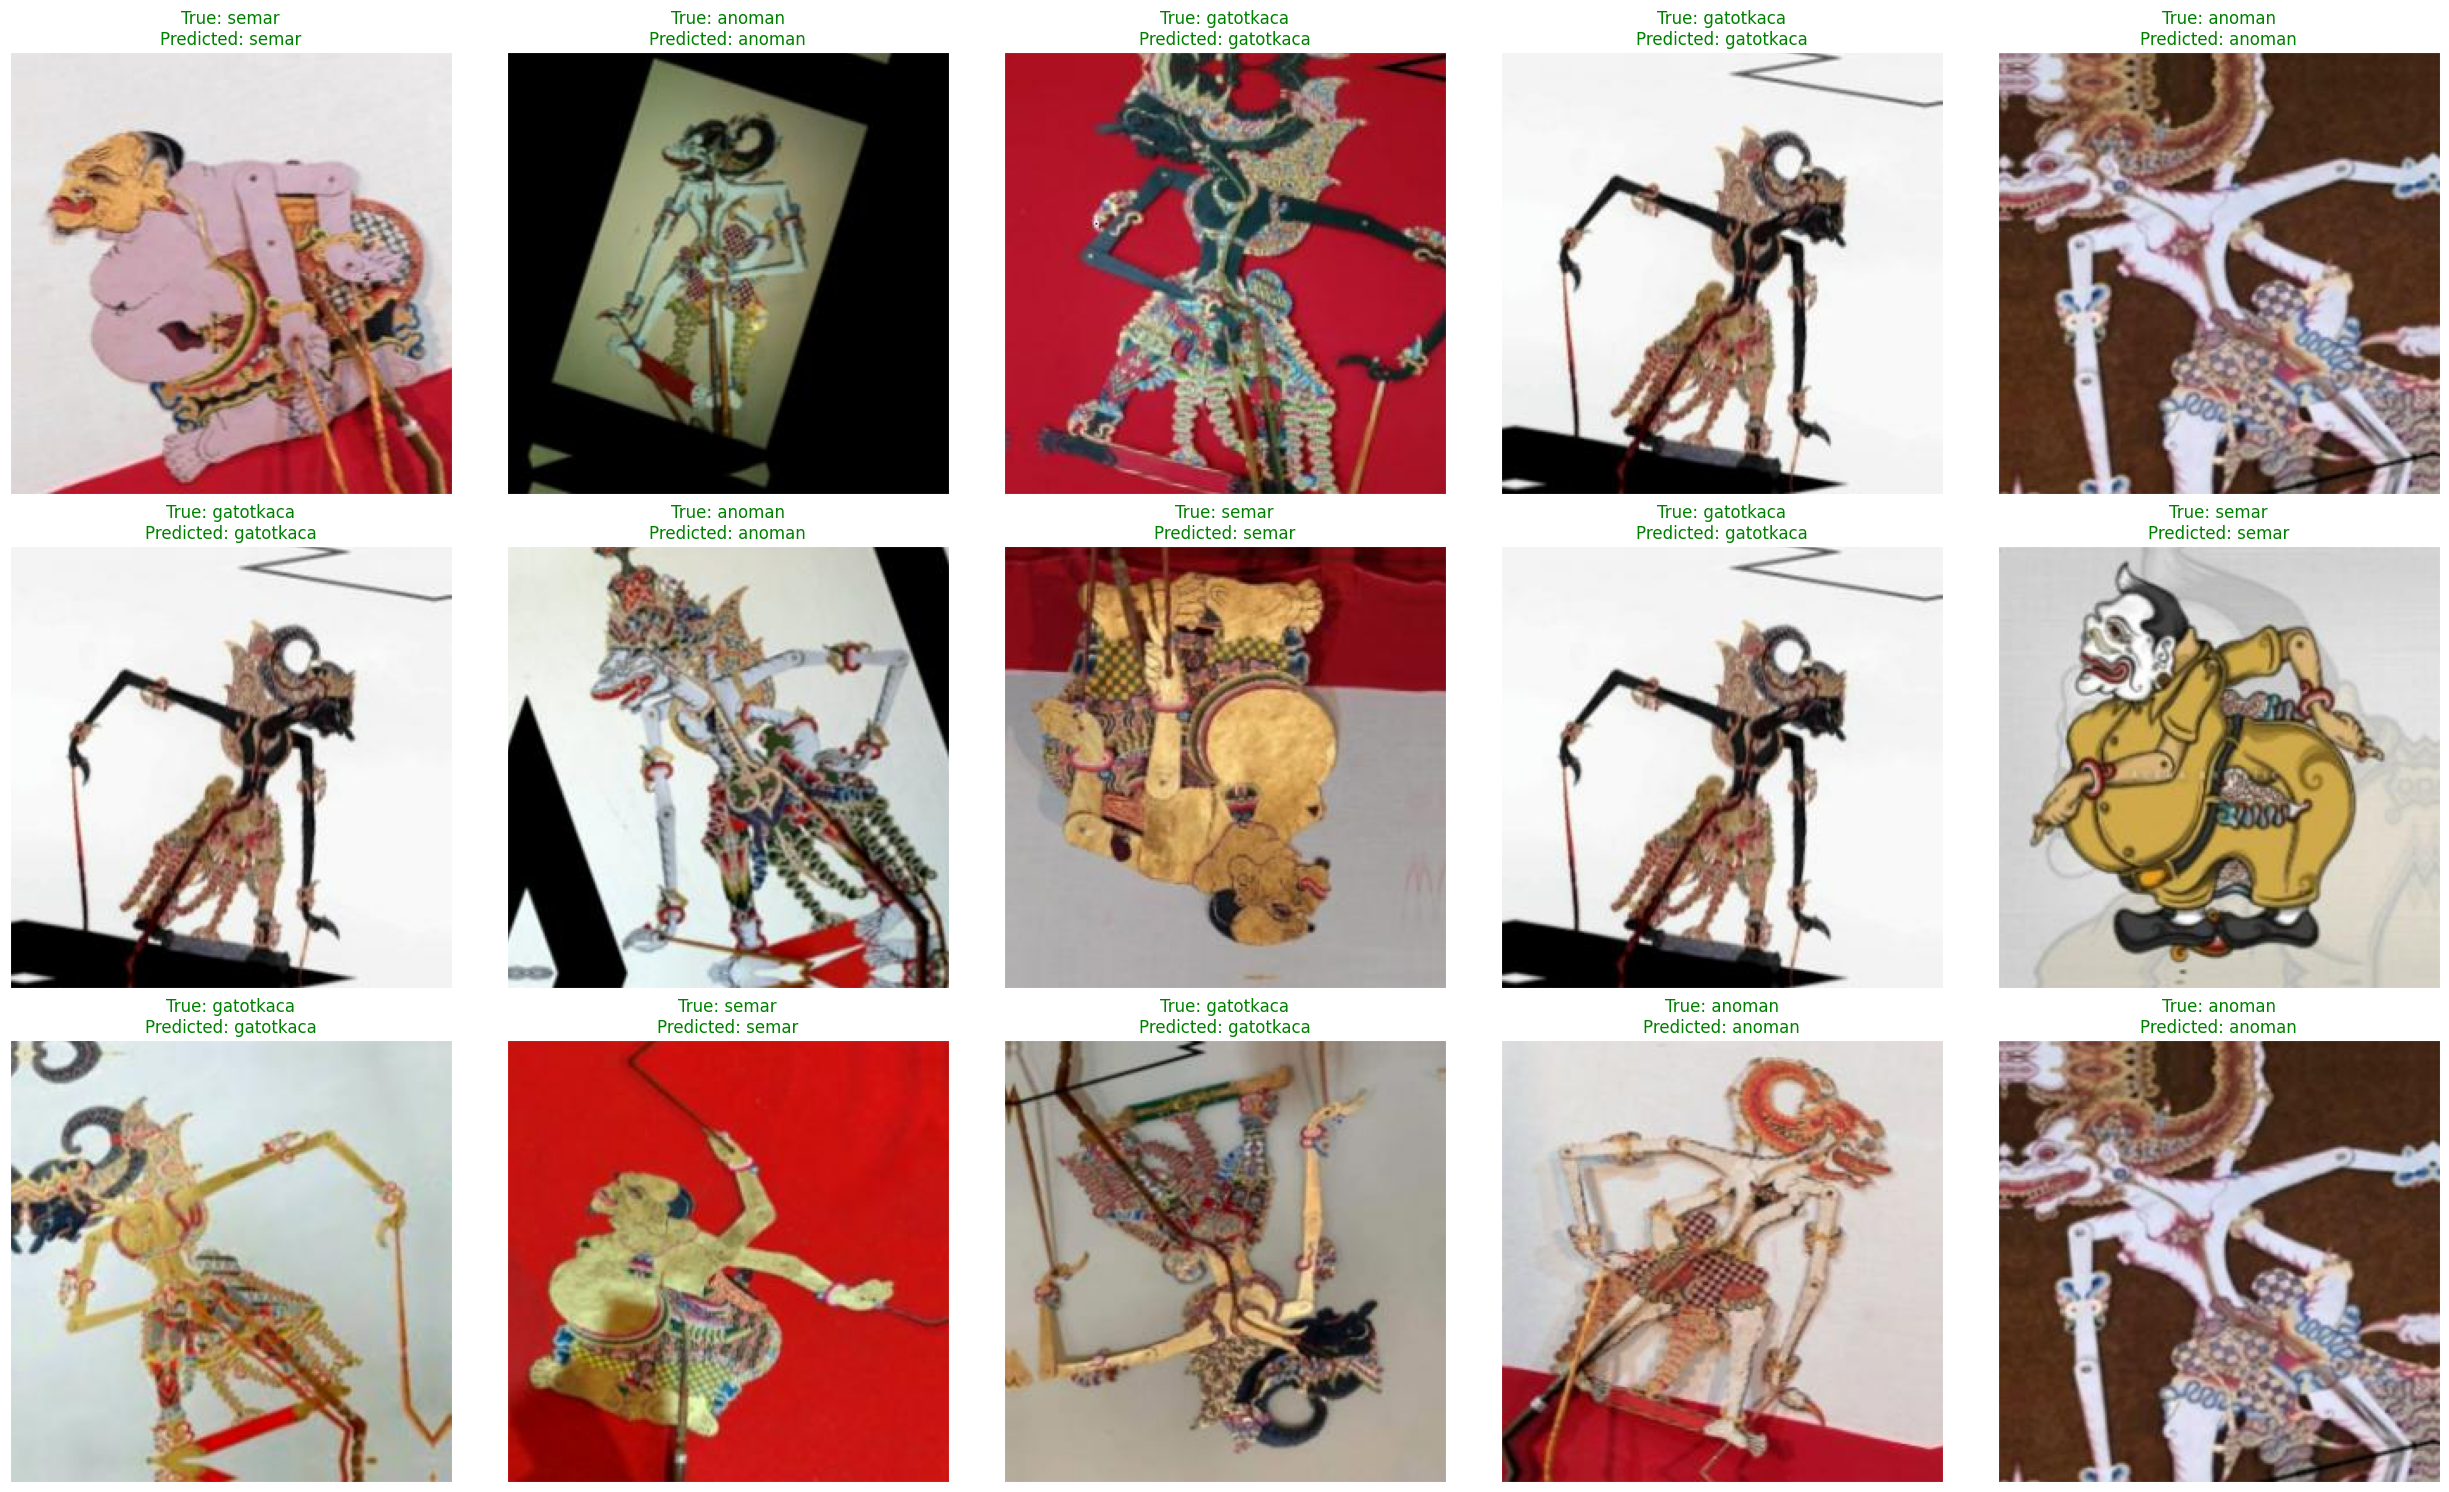

In [ ]:
# Menampilkan 25 gambar acak dari dataset dengan labelnya
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (256, 256)

for i, ax in enumerate(axes.flat):
    img = plt.imread(test_df.Filepath.iloc[random_index[i]])
    img_resized = cv2.resize(img, resize_dim)
    ax.imshow(img_resized)

    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"

    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()

#Plotting the Classification Reports and Confusion Matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      anoman       1.00      0.92      0.96        12
   gatotkaca       0.92      1.00      0.96        12
       semar       1.00      1.00      1.00        12

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score    support
anoman         1.000000  0.916667  0.956522  12.000000
gatotkaca      0.923077  1.000000  0.960000  12.000000
semar          1.000000  1.000000  1.000000  12.000000
accuracy       0.972222  0.972222  0.972222   0.972222
macro avg      0.974359  0.972222  0.972174  36.000000
weighted avg   0.974359  0.972222  0.972174  36.000000

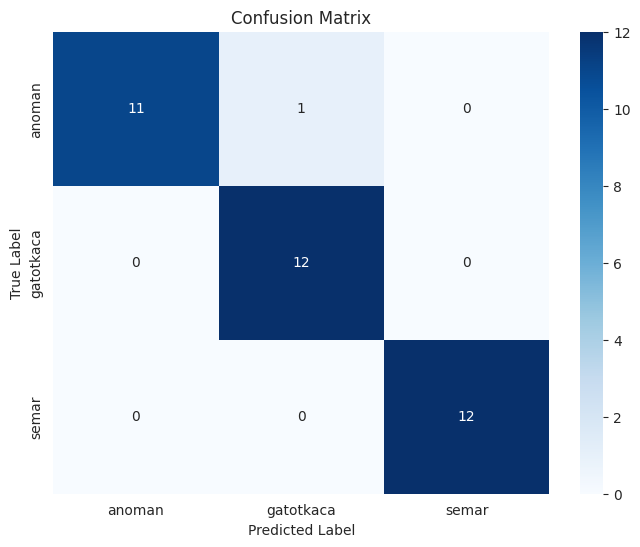

In [ ]:
# Menghitung confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot confusion matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_images.class_indices.keys(), yticklabels=test_images.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Grad-CAM Visualization

In [ ]:
# Nama layer terakhir dari EfficientNetB5 untuk Grad-CAM
last_conv_layer_name = "top_activation"
img_size = (256, 256, 3)  # Ukuran input standar untuk EfficientNetB5

def get_img_array(img_path, size):
    # Memuat gambar dan mengubah ukurannya sesuai kebutuhan model
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return preprocess_input(array)  # Gunakan preprocessing EfficientNet

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Buat model untuk mendapatkan output dari layer terakhir dan output prediksi
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Hitung gradien terhadap output layer konvolusi terakhir
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Hitung heatmap Grad-CAM
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load gambar asli
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Ubah heatmap ke format warna
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize dan gabungkan heatmap dengan gambar asli
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    return cam_path

# Nonaktifkan aktivasi softmax di layer terakhir (jika diperlukan untuk visualisasi Grad-CAM)
model.layers[-1].activation = None

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_16']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)
/tmp/ipython-input-30-3943403689.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


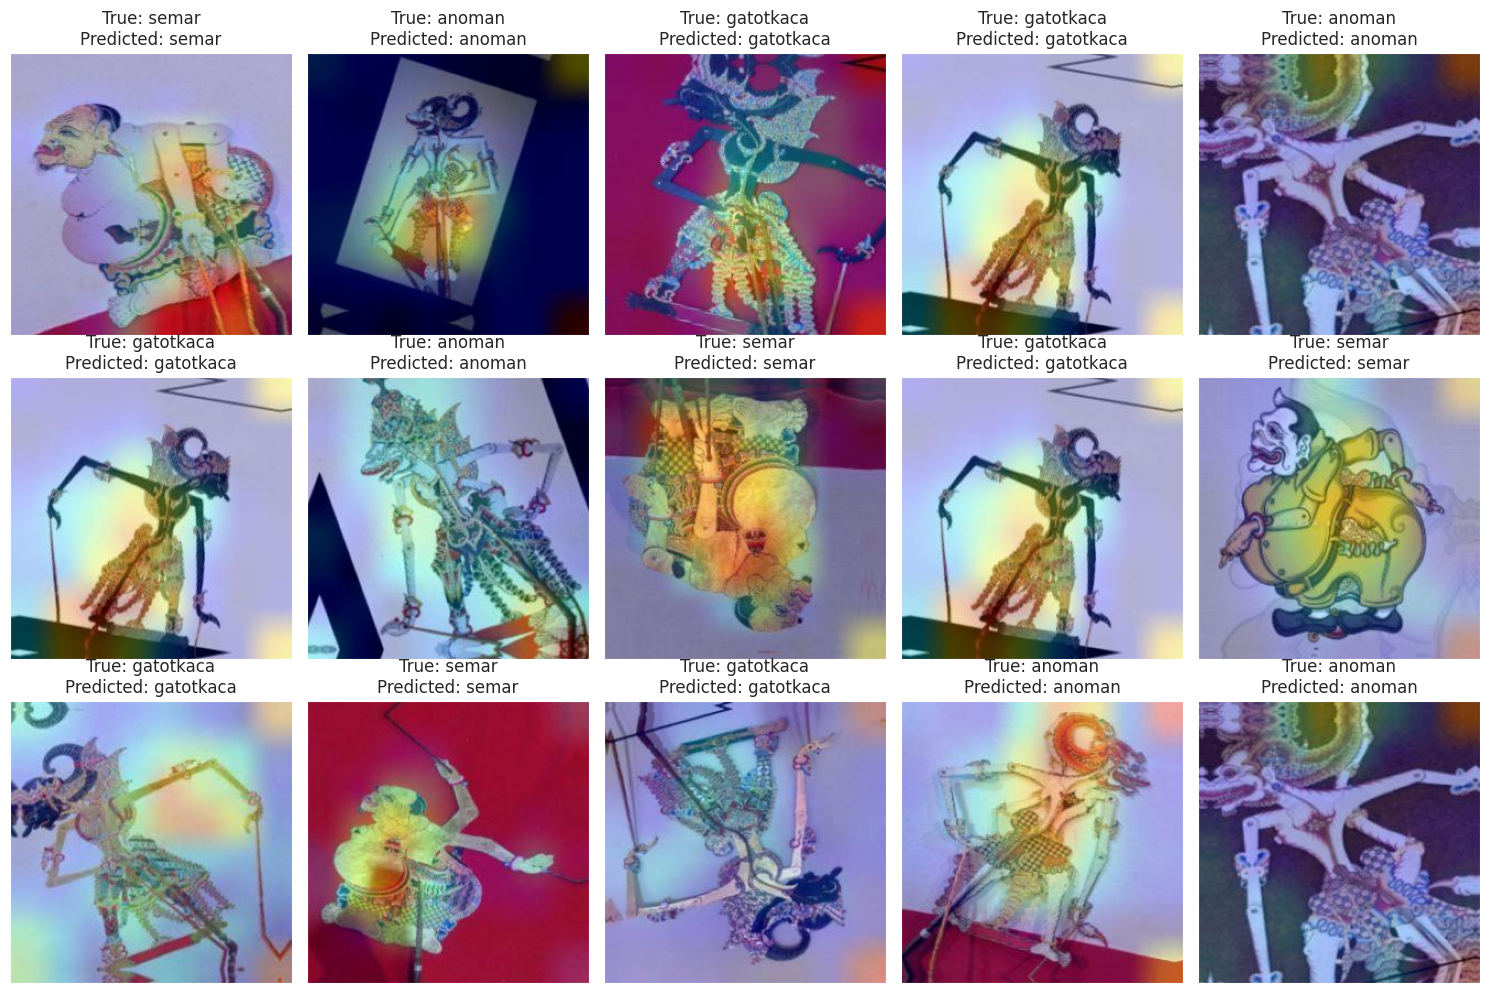

In [ ]:
import matplotlib.cm as cm
# Tampilkan bagian gambar yang digunakan oleh jaringan saraf untuk mengklasifikasikan gambar
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (256, 256)

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)

    img_resized = cv2.resize(plt.imread(cam_path), resize_dim)

    ax.imshow(img_resized)
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")

plt.tight_layout()
plt.show()